In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
file_path = '/home/yui/Downloads/QNN-test/p122_synthetic (1).csv'
data = pd.read_csv(file_path)

# Define the window size for moving calculations
window_size = 30

# Drop rows with NaN values resulting from the rolling operation
data_clean = data.dropna()



# Define the target and features
target_column = 'value'  # Replace this with the actual target column name if different
features = [col for col in data_clean.columns if col != target_column]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_clean[features], data_clean[target_column], test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the testing set
predictions = model.predict(X_test)

# Calculate Mean Squared Error and R-squared
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print the results
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 3.6313122821668984e+16
R-squared: 0.8973395448855753


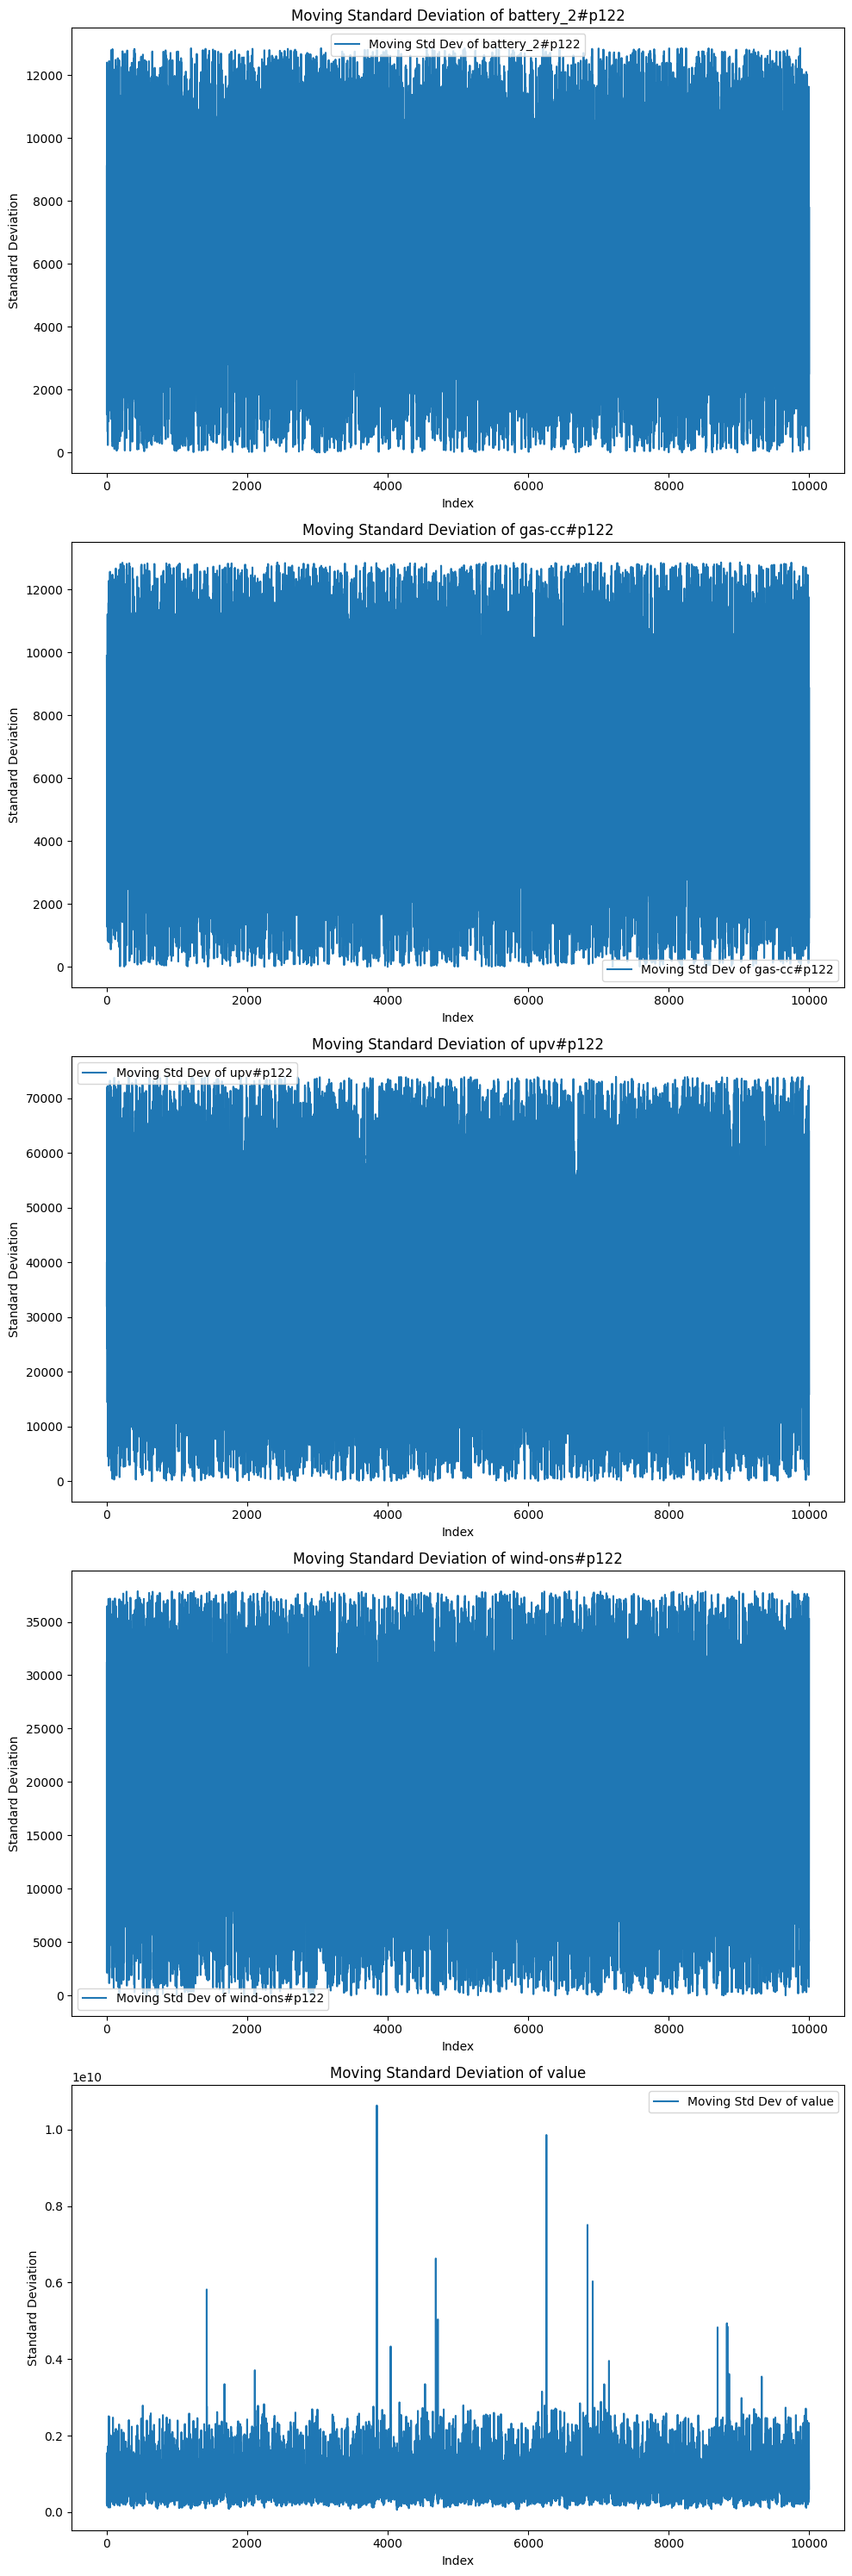

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = '/home/yui/Downloads/QNN-test/p122_synthetic (1).csv'
data = pd.read_csv(file_path)

# Define the window size for moving calculations
window_size = 30

# Calculate moving standard deviation for each column and plot them
fig, axs = plt.subplots(len(data.columns), 1, figsize=(10, 6 * len(data.columns)))  # Adjust the size as needed

for i, column in enumerate(data.columns):

    # Drop rows with NaN values resulting from the rolling operation
    data_clean = data.dropna()

    # Plotting the moving standard deviation for each column
    axs[i].plot(data_clean[column], label=f'Moving Std Dev of {column}')
    axs[i].set_title(f'Moving Standard Deviation of {column}')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Standard Deviation')
    axs[i].legend()

plt.tight_layout()  # This adjusts the plot to ensure everything fits without overlap
plt.show()


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
file_path = '/home/yui/Downloads/QNN-test/p122_synthetic (1).csv'
data = pd.read_csv(file_path)
# Feature target split
target = data['value']
features = data.drop('value', axis=1)
# Convert features and target to tensors
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)  # Ensure y is the correct shape
# Initialize the scaler
scaler = StandardScaler()
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the scaler on your TRAINING data only
X_train = scaler.fit_transform(X_train.numpy())  # Convert to NumPy array to fit
X_test = scaler.transform(X_test.numpy())  # Apply the same transform to the test data

# Convert scaled features back to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader for training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


val_dataset = TensorDataset(X_test, y_test)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

# Define the Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(features.shape[1], 64)  # Adjust the input features dynamically
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# Instantiate the model, loss function, and optimizer
model = NeuralNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the Model
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(torch.tensor(X_test, dtype=torch.float32))
    predictions = predictions.numpy()  # convert to numpy array for comparison
    y_test_numpy = y_test.numpy()  # actual values to numpy array
    r2 = r2_score(y_test_numpy, predictions)
    print(f'R-squared: {r2:.4f}')


Epoch [1/100], Loss: 819899567360180224.0000
Epoch [2/100], Loss: 1008617681567350784.0000
Epoch [3/100], Loss: 1016752418345451520.0000
Epoch [4/100], Loss: 933085287188267008.0000
Epoch [5/100], Loss: 1147763145805135872.0000
Epoch [6/100], Loss: 1108846481495818240.0000
Epoch [7/100], Loss: 1400846395824406528.0000
Epoch [8/100], Loss: 994450542962933760.0000
Epoch [9/100], Loss: 1154127668862517248.0000
Epoch [10/100], Loss: 1292665584206479360.0000
Epoch [11/100], Loss: 964402608162734080.0000
Epoch [12/100], Loss: 1048456973571325952.0000
Epoch [13/100], Loss: 1068036183285563392.0000
Epoch [14/100], Loss: 1095601489549721600.0000
Epoch [15/100], Loss: 730530643779256320.0000
Epoch [16/100], Loss: 971820806956908544.0000
Epoch [17/100], Loss: 771354685884858368.0000
Epoch [18/100], Loss: 865282390832971776.0000
Epoch [19/100], Loss: 2197437897223700480.0000
Epoch [20/100], Loss: 844118441265725440.0000
Epoch [21/100], Loss: 685526670781710336.0000
Epoch [22/100], Loss: 9273674144

/tmp/ipykernel_76095/493009191.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = model(torch.tensor(X_test, dtype=torch.float32))


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
def quantile_loss(outputs, targets, quantile):
    """
    Calculate the quantile loss for a specific quantile of the target distribution.
    
    Args:
        outputs (torch.Tensor): The predictions from the model.
        targets (torch.Tensor): The actual values of the targets.
        quantile (float): The quantile to calculate loss for (e.g., 0.5 for median).
    
    Returns:
        torch.Tensor: The calculated quantile loss.
    """
    errors = targets - outputs
    loss = torch.max((quantile - 1) * errors, quantile * errors)
    return torch.mean(loss)

file_path = '/home/yui/Downloads/QNN-test/p122_synthetic (1).csv'
data = pd.read_csv(file_path)
# Feature target split
target = data['value']
features = data.drop('value', axis=1)
# Convert features and target to tensors
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)  # Ensure y is the correct shape
# Initialize the scaler
scaler = StandardScaler()
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the scaler on your TRAINING data only
X_train = scaler.fit_transform(X_train.numpy())  # Convert to NumPy array to fit
X_test = scaler.transform(X_test.numpy())  # Apply the same transform to the test data

# Convert scaled features back to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader for training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


val_dataset = TensorDataset(X_test, y_test)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

# Define the Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(features.shape[1], 64)  # Adjust the input features dynamically
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# Instantiate the model, loss function, and optimizer
model = NeuralNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

quantile = 0.5  # Median

# Training the Model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = quantile_loss(outputs, labels, quantile)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Average loss per epoch
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Evaluate the model
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    predictions = model(X_test)
    predictions = predictions.numpy()  # Convert to numpy array for comparison
    y_test_numpy = y_test.numpy()  # Convert actual values to numpy array
    r2 = r2_score(y_test_numpy, predictions)
    print(f'R-squared: {r2:.4f}')


Epoch [1/100], Loss: 453820905.4720
Epoch [2/100], Loss: 453799660.5440
Epoch [3/100], Loss: 453706334.4640
Epoch [4/100], Loss: 453486597.8880
Epoch [5/100], Loss: 453093429.7600
Epoch [6/100], Loss: 452486823.1680
Epoch [7/100], Loss: 451631651.5840
Epoch [8/100], Loss: 450497876.7360
Epoch [9/100], Loss: 449058769.1520
Epoch [10/100], Loss: 447290697.7280
Epoch [11/100], Loss: 445172996.0960
Epoch [12/100], Loss: 442690940.4160
Epoch [13/100], Loss: 439825700.8640
Epoch [14/100], Loss: 436563058.6880
Epoch [15/100], Loss: 432889442.3040
Epoch [16/100], Loss: 428798671.8720
Epoch [17/100], Loss: 424280911.3600
Epoch [18/100], Loss: 419335581.4400
Epoch [19/100], Loss: 413968946.6880
Epoch [20/100], Loss: 408188151.2960
Epoch [21/100], Loss: 402017016.0640
Epoch [22/100], Loss: 395467795.7120
Epoch [23/100], Loss: 388580214.5280
Epoch [24/100], Loss: 381420687.1040
Epoch [25/100], Loss: 374048350.2080
Epoch [26/100], Loss: 366514035.9680
Epoch [27/100], Loss: 358935854.5920
Epoch [28/

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score

def quantile_loss(outputs, targets, quantile):
    """
    Calculate the quantile loss for a specific quantile of the target distribution.
    
    Args:
        outputs (torch.Tensor): The predictions from the model.
        targets (torch.Tensor): The actual values of the targets.
        quantile (float): The quantile to calculate loss for.
    
    Returns:
        torch.Tensor: The calculated quantile loss.
    """
    errors = targets - outputs
    loss = torch.max((quantile - 1) * errors, quantile * errors)
    return torch.mean(loss)

file_path = '/home/yui/Downloads/QNN-test/p122_synthetic (1).csv'
data = pd.read_csv(file_path)

# Feature target split
target = data['value']
features = data.drop('value', axis=1)

# Convert features and target to tensors
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)  # Ensure y is the correct shape

# Initialize the scaler
scaler = StandardScaler()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the scaler on your TRAINING data only
X_train_scaled = scaler.fit_transform(X_train.numpy())  # Convert to NumPy array to fit
X_test_scaled = scaler.transform(X_test.numpy())  # Apply the same transform to the test data

# Convert scaled features back to tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

# Create DataLoader for training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, output_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(features.shape[1], 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, output_size)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# Instantiate the models for each quantile
#quantiles = [0.05,0.25, 0.5,0.75, 0.95]
quantiles = np.concatenate([
    np.linspace(0.01, 0.49, num=24),  # Quantiles up to just below the median
    [0.5],  # The median
    np.linspace(0.51, 0.99, num=25)  # Quantiles above the median
])
models = [NeuralNet(1) for _ in quantiles]

# Instantiate the loss function and optimizer for each model
criterion = nn.MSELoss()
optimizers = [optim.Adam(model.parameters(), lr=0.01) for model in models]

# Training the Models
num_epochs = 100
for epoch in range(num_epochs):
    total_losses = [0] * len(quantiles)
    for inputs, labels in train_loader:
        for i, quantile in enumerate(quantiles):
            models[i].train()  # Set the model to training mode
            # Forward pass
            outputs = models[i](inputs)
            loss = quantile_loss(outputs, labels, quantile)

            # Backward and optimize
            optimizers[i].zero_grad()
            loss.backward()
            optimizers[i].step()
            total_losses[i] += loss.item()

    # Average loss per epoch
    avg_losses = [total_loss / len(train_loader) for total_loss in total_losses]
    print(f'Epoch [{epoch+1}/{num_epochs}], Losses: {avg_losses}')

# Evaluate the models
for i, model in enumerate(models):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predictions = model(X_test)
        predictions = predictions.numpy()  # Convert to numpy array for comparison
        r2 = r2_score(y_test.numpy(), predictions)
        print(f'Quantile: {quantiles[i]}, R-squared: {r2:.4f}')


Epoch [1/100], Losses: [9076415.88, 28018482.272, 46960576.48, 65902664.288, 84844699.008, 103786793.152, 122728945.664, 141670868.224, 160613105.664, 179555096.064, 198497199.744, 217439254.784, 236381238.784, 255323590.4, 274265558.528, 293207729.152, 312149546.112, 331091676.16, 350033946.112, 368975802.88, 387917891.328, 406860116.224, 425801990.144, 444744153.088, 453820506.624, 462896748.288, 481050002.688, 499202830.336, 517355362.816, 535508270.336, 553661305.856, 571813725.696, 589966354.176, 608119524.608, 626272184.832, 644425724.416, 662578092.8, 680731343.872, 698883450.368, 717036320.768, 735189460.992, 753341991.936, 771494807.552, 789647895.04, 807800822.272, 825953419.264, 844105826.304, 862259130.368, 880412128.256, 898564650.496]
Epoch [2/100], Losses: [9075958.872, 28016582.928, 46958013.216, 65899111.616, 84839155.328, 103780218.24, 122722792.96, 141660649.024, 160605043.648, 179544048.128, 198485642.88, 217425926.784, 236364526.464, 255311669.248, 274250662.912, 2

In [42]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score

def modified_quantile_loss(outputs, targets, previous_prediction, quantile, penalty_weight=10):
    # Standard quantile loss
    errors = targets - outputs
    quantile_losses = torch.mean(torch.max((quantile - 1) * errors, quantile * errors))
    
    # Penalty for non-monotonic predictions
    if previous_prediction is not None:
        penalty = torch.mean(torch.clamp(previous_prediction - outputs, min=0) * penalty_weight)
    else:
        penalty = 0
    
    return quantile_losses + penalty

class QuantileNet(nn.Module):
    def __init__(self, input_size):
        super(QuantileNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        return self.output_layer(x)


# Load and prepare data
data = pd.read_csv('/home/yui/Downloads/QNN-test/p122_synthetic (1).csv')
target = data['value']
features = data.drop('value', axis=1)
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)

# Scale features
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)

# DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define quantiles and models
quantiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.95]
models = [QuantileNet(features.shape[1]) for _ in quantiles]
optimizers = [optim.Adam(model.parameters(), lr=0.01) for model in models]

previous_predictions_train = torch.zeros_like(y_train)
previous_predictions_test = torch.zeros_like(y_test)

# Training loop
# Training loop

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        previous_prediction = None
        for i, (model, quantile) in enumerate(zip(models, quantiles)):
            optimizer = optimizers[i]
            optimizer.zero_grad()
            model.train()
            outputs = model(inputs)

            # Calculate loss with penalty for non-monotonic predictions
            loss = modified_quantile_loss(outputs, labels, previous_prediction, quantile)
            
            loss.backward(retain_graph=True if i < len(models) - 1 else False)
            optimizer.step()

            # Update previous prediction
            previous_prediction = outputs.detach() if previous_prediction is None else previous_prediction + outputs.detach()

# Evaluation with cumulative predictions
with torch.no_grad():
    cumulative_test_prediction = None
    for i, (model, quantile) in enumerate(zip(models, quantiles)):
        model.eval()
        test_outputs = model(X_test)
        if cumulative_test_prediction is None:
            cumulative_test_prediction = test_outputs
        else:
            cumulative_test_prediction += test_outputs
        r2 = r2_score(y_test.numpy(), cumulative_test_prediction.numpy())
        print(f'Quantile: {quantiles[i]}, Cumulative R-squared: {r2:.4f}')



Quantile: 0.05, Cumulative R-squared: 0.7078
Quantile: 0.1, Cumulative R-squared: -0.3720
Quantile: 0.25, Cumulative R-squared: -15.8669
Quantile: 0.5, Cumulative R-squared: -114.1684
Quantile: 0.75, Cumulative R-squared: -422.2821
Quantile: 0.95, Cumulative R-squared: -921.0473


In [31]:
# Store predictions for each quantile
predictions_per_quantile = {}
for i, model in enumerate(models):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        predictions = model(X_test)
        predictions = predictions.numpy()  # Convert to numpy array for comparison
        predictions_per_quantile[quantiles[i]] = predictions

# Check for Quantile Crossing
quantile_crossing = False
for i in range(len(quantiles) - 1):
    current_quantile = quantiles[i]
    next_quantile = quantiles[i + 1]
    current_predictions = predictions_per_quantile[current_quantile]
    next_predictions = predictions_per_quantile[next_quantile]
    if current_predictions.mean() > next_predictions.mean():
        quantile_crossing = True
        break

if quantile_crossing:
    print("Quantile crossing detected.")
else:
    print("No quantile crossing detected.")


No quantile crossing detected.


In [9]:
import torch.nn as nn
import torch.optim as optim

class QuantileNetwork(nn.Module):
    def __init__(self, input_size, num_quantiles):
        super(QuantileNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_quantiles)
        )

    def forward(self, x):
        return self.network(x)

def quantile_loss(preds, target, quantiles):
    assert len(quantiles) == preds.shape[1], "Quantiles size must match predictions width."
    errors = target.unsqueeze(1) - preds
    return torch.max((quantiles - 1) * errors**2, quantiles * errors**2).mean()

# Initialize the model
num_features = X_train.shape[1]
num_quantiles = 50
quantiles = torch.linspace(0.01, 0.99, steps=num_quantiles)
model = QuantileNetwork(input_size=num_features, num_quantiles=num_quantiles)

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = quantile_loss(preds, batch_y, quantiles)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 6364814848.0
Epoch 2, Loss: 6415205888.0
Epoch 3, Loss: 6291462656.0
Epoch 4, Loss: 6314597888.0
Epoch 5, Loss: 6131255808.0
Epoch 6, Loss: 5665738752.0
Epoch 7, Loss: 6200896512.0
Epoch 8, Loss: 6032240640.0
Epoch 9, Loss: 6243320320.0
Epoch 10, Loss: 6124221440.0
Epoch 11, Loss: 5662082560.0
Epoch 12, Loss: 6196228096.0
Epoch 13, Loss: 6352038912.0
Epoch 14, Loss: 6006970880.0
Epoch 15, Loss: 6249884672.0
Epoch 16, Loss: 6360613376.0
Epoch 17, Loss: 6407648768.0
Epoch 18, Loss: 6347507712.0
Epoch 19, Loss: 6797496320.0
Epoch 20, Loss: 6206689792.0
Epoch 21, Loss: 6032711168.0
Epoch 22, Loss: 6304288768.0
Epoch 23, Loss: 5556603904.0
Epoch 24, Loss: 5939987968.0
Epoch 25, Loss: 6186130432.0
Epoch 26, Loss: 6089611264.0
Epoch 27, Loss: 6429102080.0
Epoch 28, Loss: 6134003200.0
Epoch 29, Loss: 6332724224.0
Epoch 30, Loss: 6097154048.0
Epoch 31, Loss: 6354560000.0
Epoch 32, Loss: 6327782400.0
Epoch 33, Loss: 6304242176.0
Epoch 34, Loss: 5821998080.0
Epoch 35, Loss: 6051617

In [17]:
import torch

# Set the number of quantiles
num_quantiles = 50

# Generate quantiles from 1% to 99% evenly spaced
quantiles = torch.linspace(0.01, 0.99, steps=num_quantiles)

# Print the first few quantiles to see their values
print("First few quantiles:", quantiles[:26].numpy())


First few quantiles: [0.01       0.03       0.05       0.07       0.09       0.11
 0.13       0.14999999 0.17       0.19       0.21       0.22999999
 0.25       0.26999998 0.29       0.31       0.32999998 0.35
 0.37       0.39       0.41       0.42999998 0.45       0.47
 0.48999998 0.51      ]


current best:Best Configuration: (128, (64, 128, 256), 0.3, 'RMSprop', 0.01) with Loss: 151818317.0

In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Specify quantiles manually to include the median
quantiles = np.concatenate([
    np.linspace(0.01, 0.49, num=24),  # Quantiles up to just below the median
    [0.5],  # The median
    np.linspace(0.51, 0.99, num=25)  # Quantiles above the median
])
quantiles = torch.tensor(quantiles, dtype=torch.float32)
# Load data
file_path = '/home/yui/Downloads/QNN-test/p122_synthetic (1).csv'
data = pd.read_csv(file_path)

# Feature and target split
target = data['value']
features = data.drop('value', axis=1)

# Convert features and target to tensors
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)

# Initialize the scaler
scaler = StandardScaler()

# Split the data into training, testing, and final validation sets (60-30-10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 * 0.4 = 0.1

# Fit the scaler on your TRAINING data only and transform the test and validation data
X_train = scaler.fit_transform(X_train.numpy())
X_test = scaler.transform(X_test.numpy())
X_val = scaler.transform(X_val.numpy())

# Convert scaled features back to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Continue with model definition and training as you have previously defined

num_features = X_train.shape[1]
num_quantiles = 50
quantiles = torch.linspace(0.01, 0.99, steps=num_quantiles)
def quantile_loss(preds, target, quantiles):
    assert len(quantiles) == preds.shape[1], "Quantiles size must match predictions width."
    errors = target.unsqueeze(1) - preds
    return torch.max((quantiles-1) * errors, quantiles * errors).mean()
# Define Quantile Network with three hidden layers
 

# Train and evaluate model
def train_and_evaluate(model, train_loader, val_loader, optimizer, quantiles, epochs=2000):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = quantile_loss(output, target, quantiles)
            loss.backward()
            optimizer.step()

    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = quantile_loss(output, target, quantiles)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    return avg_loss

# Hyperparameter search space adjustments
neurons_options = [
    (32, 64, 128),
    (64, 128, 256),
    (128, 256, 512),
    (64, 64, 64),
    (128, 128, 128),
    (256, 256, 256),
]
batch_sizes = [64, 128, 256, 512]#[64, 128, 256, 512]
neurons = [32, 64, 128, 256]
optimizers_dict = {'Adam': optim.Adam, 'Adagrad': optim.Adagrad, 'RMSprop': optim.RMSprop}
dropout_rates = np.linspace(0, 0.5, num=5)
# Adjusting learning rates to include higher values
learning_rates = np.logspace(-5, 1, num=7)  # Now includes rates from 1e-5 to 1e1
# Calculate the total number of iterations
total_iterations = len(batch_sizes) * len(neurons_options) * len(dropout_rates) * len(optimizers_dict) * len(learning_rates)
current_iteration = 0
# Hyperparameter search
best_loss = np.inf
best_config = None
best_model=None
# Assuming you have already transformed your data and created DataLoaders

# Check the correct number of features
num_features = X_train.shape[1]  # This should give you the correct number of features


class QuantileNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, dropout_rate):
        super(QuantileNetwork, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_sizes[-1], output_size))  # Output size matches the number of quantiles
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Update hyperparameter search section with the correct input size
for batch_size in batch_sizes:
    for hidden_sizes in neurons_options:
        for dropout_rate in dropout_rates:
            for optimizer_name, optimizer_class in optimizers_dict.items():
                for lr in learning_rates:
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
                    model = QuantileNetwork(input_size=num_features, output_size=num_quantiles, hidden_sizes=hidden_sizes, dropout_rate=dropout_rate)
                    optimizer = optimizer_class(model.parameters(), lr=lr)
                    loss = train_and_evaluate(model, train_loader, val_loader, optimizer, quantiles, epochs=100)
                    if loss < best_loss:
                        best_loss = loss
                        best_config = (batch_size, hidden_sizes, dropout_rate, optimizer_name, lr)
                        best_model = model
                        print(f"Best Configuration So far: {best_config} with Loss: {best_loss}")
                        print(f"Search done for {batch_size},{hidden_sizes},{dropout_rate},{optimizer_name},{lr}")
                    current_iteration += 1
                    completion_percentage = (current_iteration / total_iterations) * 100
                    print(f"Completed: {completion_percentage:.2f}%")

print(f"Best Configuration: {best_config} with Loss: {best_loss}")


Best Configuration So far: (64, (32, 64, 128), 0.0, 'Adam', 9.999999999999999e-06) with Loss: 450855772.0
Search done for 64,(32, 64, 128),0.0,Adam,9.999999999999999e-06
Completed: 0.04%
Completed: 0.08%
Best Configuration So far: (64, (32, 64, 128), 0.0, 'Adam', 0.001) with Loss: 154218743.5
Search done for 64,(32, 64, 128),0.0,Adam,0.001
Completed: 0.12%
Best Configuration So far: (64, (32, 64, 128), 0.0, 'Adam', 0.01) with Loss: 152565077.0
Search done for 64,(32, 64, 128),0.0,Adam,0.01
Completed: 0.16%
Best Configuration So far: (64, (32, 64, 128), 0.0, 'Adam', 0.09999999999999999) with Loss: 151819977.5
Search done for 64,(32, 64, 128),0.0,Adam,0.09999999999999999
Completed: 0.20%
Completed: 0.24%
Completed: 0.28%
Completed: 0.32%
Completed: 0.36%
Completed: 0.40%
Completed: 0.44%
Completed: 0.48%
Completed: 0.52%
Completed: 0.56%
Completed: 0.60%
Completed: 0.63%
Completed: 0.67%
Completed: 0.71%
Completed: 0.75%
Completed: 0.79%
Completed: 0.83%
Completed: 0.87%
Completed: 0.91%

KeyboardInterrupt: 

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
file_path = '/home/yui/Downloads/QNN-test/p122_synthetic (1).csv'
data = pd.read_csv(file_path)

# Feature and target split
target = data['value']
features = data.drop('value', axis=1)

# Convert features and target to tensors
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)

# Initialize the scaler
scaler = StandardScaler()

# Split the data into training, testing, and final validation sets (60-30-10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Fit the scaler on your TRAINING data only and transform the test and validation data
X_train = scaler.fit_transform(X_train.numpy())
X_test = scaler.transform(X_test.numpy())
X_val = scaler.transform(X_val.numpy())

# Convert scaled features back to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the Quantile Network class
class QuantileNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, dropout_rate):
        super(QuantileNetwork, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define the quantiles and loss function
num_quantiles = 1
# Redefine quantiles to explicitly include the median (0.50)
quantiles = np.concatenate([
 # Quantiles up to just below the median
    [0.50]                         # Explicitly include the median
  # Quantiles above the median
])
quantiles = torch.tensor(quantiles, dtype=torch.float32)

# Print the updated quantiles to verify inclusion
print("Updated quantiles:", quantiles)
def quantile_loss(preds, target, quantiles):
    assert len(quantiles) == preds.shape[1], "Quantiles size must match predictions width."
    errors = target.unsqueeze(1) - preds
    return torch.max((quantiles-1 ) * errors**2, quantiles * errors**2).mean()

# Instantiate and train the model
model = QuantileNetwork(input_size=X_train.shape[1], output_size=num_quantiles, hidden_sizes=(100, 100), dropout_rate=0.25)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

def train_and_evaluate(model, train_loader, val_loader, optimizer, quantiles, epochs=100):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = quantile_loss(output, target, quantiles)
            loss.backward()
            optimizer.step()

    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = quantile_loss(output, target, quantiles)
            total_loss += loss.item()
    return total_loss / len(val_loader)

# Train the model
train_loss = train_and_evaluate(model, train_loader, val_loader, optimizer, quantiles, epochs=100)
print(f"Training completed with Loss: {train_loss}")

# Predict on validation set
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(X_val, dtype=torch.float32))

# Optionally, convert predictions to a DataFrame or any other format as needed
predictions_np = predictions.numpy()
predictions_df = pd.DataFrame(predictions_np, columns=[f'Quantile_{q:.2f}' for q in quantiles])

import torch
from sklearn.metrics import r2_score

# Assuming model and data loaders are already defined and set up
model.eval()
# Predict on training data
with torch.no_grad():
    train_predictions = model(torch.tensor(X_train, dtype=torch.float32)).numpy()

# Find the index for the median in the quantiles array
median_index = (quantiles == 0.50).nonzero(as_tuple=True)[0].item()

# Extract the median predictions using the found index
median_train_predictions = train_predictions[:, median_index]

# Flatten y_train to ensure dimension compatibility
y_train_flattened = y_train.flatten()

# Calculate R-squared using sklearn's r2_score function
r_squared_train = r2_score(y_train_flattened, median_train_predictions)
print(f"R-squared for the median on the training dataset: {r_squared_train}")
# Predict on validation data
with torch.no_grad():
    val_predictions = model(torch.tensor(X_val, dtype=torch.float32)).numpy()

# Find the index for the median in the updated quantiles array
median_index = (quantiles == 0.50).nonzero(as_tuple=True)[0].item()

# Extract the median predictions using the found index
median_predictions = val_predictions[:, median_index]

# Calculate R-squared using sklearn's r2_score function
r_squared = r2_score(y_val.flatten(), median_predictions)  # Ensure y_val is flattened to match dimensions
print(f"R-squared for the median on the validation dataset: {r_squared}")



Updated quantiles: tensor([0.5000])
Training completed with Loss: 1.5990829231374336e+17
R-squared for the median on the training dataset: 0.049606607766818356
R-squared for the median on the validation dataset: 0.04681297149092456


/tmp/ipykernel_120188/3015993314.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = model(torch.tensor(X_val, dtype=torch.float32))
/tmp/ipykernel_120188/3015993314.py:126: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = model(torch.tensor(X_train, dtype=torch.float32)).numpy()
/tmp/ipykernel_120188/3015993314.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = model(torch.tensor(X_val, dtype=torch.float32)).numpy()


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
file_path = '/home/yui/Downloads/QNN-test/p122_synthetic (1).csv'
data = pd.read_csv(file_path)

# Feature and target split
target = data['value']
features = data.drop('value', axis=1)

# Convert features and target to tensors
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)

# Initialize the scaler
scaler = StandardScaler()

# Split the data into training, testing, and validation sets (60-30-10)
X_train, X_temp, y_train, y_temp = train_test_split(X.numpy(), y.numpy(), test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Fit the scaler on your TRAINING data only and transform the test and validation data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Convert scaled features back to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.float32))
val_dataset = TensorDataset(X_val, torch.tensor(y_val, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the Quantile Network class
class QuantileNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, dropout_rate):
        super(QuantileNetwork, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU(), nn.Dropout(dropout_rate)]
        for i in range(1, len(hidden_sizes)):
            layers += [nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]), nn.ReLU(), nn.Dropout(dropout_rate)]
        layers += [nn.Linear(hidden_sizes[-1], output_size)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

quantiles = torch.tensor([0.10, 0.50, 0.90], dtype=torch.float32)  # Define quantiles for the model to predict

def quantile_loss(preds, target, quantiles):
    errors = target.unsqueeze(1) - preds
    return torch.mean(torch.max((quantiles - 1) * errors, quantiles * errors))

# Instantiate the model, optimizer
model = QuantileNetwork(input_size=X_train.shape[1], output_size=len(quantiles), hidden_sizes=[40, 40], dropout_rate=0.25)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

def train_and_evaluate(model, train_loader, val_loader, optimizer, quantiles, epochs=100):
    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = quantile_loss(output, target, quantiles)
            loss.backward()
            optimizer.step()

        model.eval()
        total_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                output = model(data)
                loss = quantile_loss(output, target, quantiles)
                total_loss += loss.item()
        print(f"Epoch {epoch+1}, Validation Loss: {total_loss / len(val_loader)}")

train_and_evaluate(model, train_loader, val_loader, optimizer, quantiles, 100)

# Saving the model and scaler
torch.save(model.state_dict(), 'quantile_model.pth')
torch.save(scaler, 'scaler.pth')




Updated quantiles: tensor([0.5000, 0.5000, 0.9500])
Training completed with Loss: -767249764.0


/tmp/ipykernel_120188/2572504980.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = model(torch.tensor(X_val, dtype=torch.float32))
/tmp/ipykernel_120188/2572504980.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = model(torch.tensor(X_train, dtype=torch.float32)).numpy()


RuntimeError: a Tensor with 2 elements cannot be converted to Scalar

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
file_path = '/home/yui/Downloads/QNN-test/p122_synthetic (1).csv'
data = pd.read_csv(file_path)

# Feature and target split
target = data['value']
features = data.drop('value', axis=1)

# Convert features and target to tensors
X = torch.tensor(features.values, dtype=torch.float32)
y = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)

# Initialize the scaler
scaler = StandardScaler()

# Split the data into training, testing, and final validation sets (60-30-10)
X_train, X_temp, y_train, y_temp = train_test_split(X.numpy(), y.numpy(), test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Fit the scaler on your TRAINING data only and transform the test and validation data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


# Convert scaled features back to tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(X_test, torch.tensor(y_test, dtype=torch.float32))
val_dataset = TensorDataset(X_val, torch.tensor(y_val, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define the Quantile Network class
class QuantileNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, dropout_rate):
        super(QuantileNetwork, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            layers.append(nn.Linear(input_size if i == 0 else hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define quantiles and loss function
quantiles = torch.tensor([0.1, 0.5, 0.9], dtype=torch.float32)

def quantile_loss(preds, target, quantiles):
    errors = target - preds
    loss = torch.where(errors > 0, (quantiles-1) * errors**2, quantiles * errors**2)
    return torch.mean(loss)

# Instantiate and train the model
model = QuantileNetwork(input_size=X_train.shape[1], output_size=len(quantiles), hidden_sizes=[40, 40], dropout_rate=0.25)
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

def train_and_evaluate(model, train_loader, val_loader, optimizer, quantiles, epochs=100):
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = quantile_loss(output, target, quantiles)
            loss.backward()
            optimizer.step()

    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            loss = quantile_loss(output, target, quantiles)
            total_loss += loss.item()
    return total_loss / len(val_loader)

train_loss = train_and_evaluate(model, train_loader, val_loader, optimizer, quantiles, 100)
print(f'Training completed with loss: {train_loss}')

# Save model
torch.save(model.state_dict(), 'quantile_model.pth')

# Predict using the model
model.eval()
with torch.no_grad():
    predictions = model(X_val)


model.load_state_dict(torch.load('quantile_model.pth'))
model.eval()

# Example prediction
def predict(input_features):
    input_tensor = torch.tensor(scaler.transform([input_features]), dtype=torch.float32)
    with torch.no_grad():
        return model(input_tensor).numpy()

# Use predict function
example_features = features.iloc[0].drop('value').values
prediction = predict(example_features)
print("Predicted Quantiles:", prediction)

# First, generate predictions for the test set if not already available
model.eval()
with torch.no_grad():
    test_predictions = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

# Calculate the baseline prediction using the median of the training data
baseline_pred = np.median(y_train)

def pseudo_r_squared(y_true, y_pred, baseline):
    """
    Calculate a pseudo R-squared for quantile regression.

    Args:
        y_true (np.array): True target values.
        y_pred (np.array): Predictions from the quantile regression model.
        baseline (np.array): Predictions from a baseline model (e.g., median of y_true).

    Returns:
        float: Pseudo R-squared value.
    """
    # Sum of absolute deviations for the baseline model
    baseline_dev = np.sum(np.abs(y_true - baseline))
    
    # Sum of absolute deviations for the quantile model
    model_dev = np.sum(np.abs(y_true - y_pred))
    
    # Calculate pseudo R-squared
    return 1 - (model_dev / baseline_dev)

# Calculate pseudo R-squared for each quantile in the test set
quantile_results = {}
for i, q in enumerate(quantiles.numpy()):
    r_squared = pseudo_r_squared(y_test.flatten(), test_predictions[:, i], baseline_pred)
    quantile_results[f"Quantile {q:.2f}"] = r_squared

# Print the results
for quantile, r_squared in quantile_results.items():
    print(f"{quantile}: Pseudo R-squared = {r_squared:.3f}")



Training completed with loss: -7.050872197220401e+18


NameError: name 'example_features' is not defined

In [4]:
import torch
from sklearn.preprocessing import StandardScaler

# Assuming 'model' and 'scaler' are your trained model and scaler instances
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler
}, '/home/yui/Downloads/QNN-test/model_and_scaler.pth')


In [5]:
def load_model_and_scaler(filepath):
    # Load saved model and scaler
    checkpoint = torch.load(filepath)
    model_state_dict = checkpoint['model_state_dict']
    loaded_scaler = checkpoint['scaler']

    # Assuming the model architecture is defined somewhere as QuantileNetwork
    loaded_model = QuantileNetwork(input_size=X_train.shape[1], output_size=num_quantiles, hidden_sizes=(40, 40), dropout_rate=0.25)
    loaded_model.load_state_dict(model_state_dict)
    loaded_model.eval()  # Set the model to evaluation mode

    return loaded_model, loaded_scaler

# Path where the model and scaler are saved
filepath = '/home/yui/Downloads/QNN-test/model_and_scaler.pth'
model, scaler = load_model_and_scaler(filepath)


In [6]:
def predict_quantiles(data, model, scaler, quantiles):
    # Drop the target column and convert to numpy if it's a DataFrame
    if isinstance(data, pd.DataFrame):
        features = data.drop('value', axis=1).values
    else:
        features = data  # Assuming it's already a numpy array without the target column
    
    # Scale the features
    features_scaled = scaler.transform(features)
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32)

    # Make predictions
    with torch.no_grad():
        predictions = model(features_tensor)

    # Convert predictions to a DataFrame for easy viewing
    predictions_np = predictions.numpy()
    predictions_df = pd.DataFrame(predictions_np, columns=[f'Quantile_{q:.2f}' for q in quantiles.numpy()])

    return predictions_df

# Example usage
file_path = '/home/yui/Downloads/QNN-test/p122_synthetic (1).csv'
data = pd.read_csv(file_path)
predictions_df = predict_quantiles(data, model, scaler, quantiles)

print(predictions_df.head())


   Quantile_0.01  Quantile_0.03  Quantile_0.05  Quantile_0.07  Quantile_0.09  \
0    135758656.0    181759616.0    212279520.0    239181552.0    265237776.0   
1    158744496.0    212505648.0    248173488.0    279613408.0    310065632.0   
2    145054048.0    194201888.0    226808848.0    255550720.0    283389408.0   
3    146028320.0    195486608.0    228299648.0    257223104.0    285237984.0   
4    179552032.0    240377168.0    280731296.0    316301824.0    350755104.0   

   Quantile_0.11  Quantile_0.14  Quantile_0.16  Quantile_0.18  Quantile_0.20  \
0    291242048.0    317623200.0    344438656.0    371658336.0    399007392.0   
1    340456704.0    371288320.0    402628032.0    434440224.0    466403136.0   
2    311172256.0    339358080.0    368008224.0    397090688.0    426310912.0   
3    313196608.0    341560640.0    370392064.0    399658272.0    429063232.0   
4    385139072.0    420021792.0    455479520.0    491472384.0    527635328.0   

   ...  Quantile_0.80  Quantile_0.82  

Garbege

In [18]:
import pandas as pd

# Ensure the model is in evaluation mode
best_model.eval()

# Prepare the full dataset (you can choose train, test, or validation depending on the requirement)
X_full_tensor = torch.tensor(features.values, dtype=torch.float32)  # Assuming 'features' contains the full feature set
y_full_tensor = torch.tensor(target.values, dtype=torch.float32).unsqueeze(1)  # Ensure it matches the expected input

# Make predictions
with torch.no_grad():
    full_predictions = best_model(X_full_tensor)

# Convert predictions to numpy for easier manipulation
full_predictions_np = full_predictions.numpy()

# Convert the full target tensor back to numpy if needed
y_full_np = y_full_tensor.numpy()

# Create a DataFrame for the predictions
predictions_df = pd.DataFrame(full_predictions_np, columns=[f'Quantile_{q:.2f}' for q in quantiles.numpy()])

# Concatenate the original data with the predictions
enhanced_data = pd.concat([data, predictions_df], axis=1)

# Save the enhanced dataset to a new CSV file
enhanced_data.to_csv('/home/yui/Downloads/QNN-test/p122_synthetic_with_predictions.csv', index=False)

print("Enhanced dataset with predictions saved successfully.")


Enhanced dataset with predictions saved successfully.


/tmp/ipykernel_76095/3899058657.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=torch.float32)  # Assuming X_val is already scaled and converted to tensor


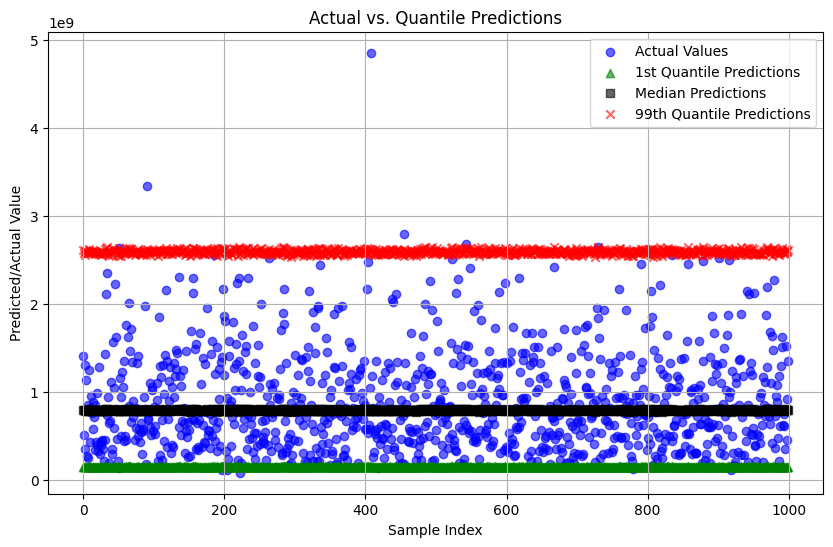

In [10]:
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
best_model.eval()

# Prepare validation data
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)  # Assuming X_val is already scaled and converted to tensor

# Make predictions with the model
with torch.no_grad():
    predictions = best_model(X_val_tensor)

# Convert predictions to a numpy array for easier manipulation
predictions_np = predictions.numpy()

# Calculate indices for desired quantiles
bottom_quantile_index = 0  # 1st percentile
median_index = num_quantiles // 2  # 50th percentile (median)
top_quantile_index = num_quantiles - 1  # 99th percentile

# Extract predictions for the specified quantiles
bottom_quantile_predictions = predictions_np[:, bottom_quantile_index]
median_predictions = predictions_np[:, median_index]
top_quantile_predictions = predictions_np[:, top_quantile_index]

# Actual values for validation set
y_val_np = y_val.numpy().flatten()  # Flatten to match the prediction dimensions

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_val_np)), y_val_np, color='blue', label='Actual Values', alpha=0.6, marker='o')
plt.scatter(range(len(bottom_quantile_predictions)), bottom_quantile_predictions, color='green', label='1st Quantile Predictions', alpha=0.6, marker='^')
plt.scatter(range(len(median_predictions)), median_predictions, color='black', label='Median Predictions', alpha=0.6, marker='s')
plt.scatter(range(len(top_quantile_predictions)), top_quantile_predictions, color='red', label='99th Quantile Predictions', alpha=0.6, marker='x')
plt.title('Actual vs. Quantile Predictions')
plt.xlabel('Sample Index')
plt.ylabel('Predicted/Actual Value')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
def quantile_loss(preds, target, quantiles):
    assert len(quantiles) == preds.shape[1], "Quantiles size must match predictions width."
    errors = target.unsqueeze(1) - preds
    return torch.max((quantiles - 1) * errors, quantiles * errors).mean()
import torch

# Convert y_val to a tensor (assuming y_val was previously prepared and needs conversion)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Make sure the model is in evaluation mode
best_model.eval()

# Prepare X_val as a tensor if not already (assuring that X_val_tensor is prepared)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)  # This line assumes X_val needs conversion; adjust if already converted

# Compute predictions and loss using the tensors
with torch.no_grad():
    val_preds = best_model(X_val_tensor)
    val_loss = quantile_loss(val_preds, y_val_tensor, quantiles).item()

print(f"Validation Loss: {val_loss}")



Validation Loss: 152305360.0


/tmp/ipykernel_76095/2696913218.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
/tmp/ipykernel_76095/2696913218.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(X_val, dtype=torch.float32)  # This line assumes X_val needs conversion; adjust if already converted


In [14]:
range_y = y_train.max() - y_train.min()
normalized_loss = val_loss / range_y
print(f"Normalized Loss: {normalized_loss}")
def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions) / targets)) * 100

# Assuming median_predictions and y_val_np are already defined and are numpy arrays
median_mape = mape(median_predictions, y_val_np)
print(f"Median MAPE: {median_mape}%")


Normalized Loss: 0.014404874294996262
Median MAPE: 67.33797788619995%


In [ ]:
!pip install matplotlib
!pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns
import torch

def evaluate_and_plot_quantiles_direct(model, loader, quantiles):
    model.eval()
    all_preds = []
    all_targets = []

    # Collect predictions and targets
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            all_preds.append(output)
            all_targets.append(target)

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Initialize counters for each quantile
    quantile_counts = [0] * (len(quantiles) + 1)  # Including one extra for above highest quantile

    # Assign each target to the highest quantile it does not exceed
    for i, target in enumerate(all_targets):
        # Find the highest quantile that the target value does not exceed
        for j in range(len(quantiles)):
            if target <= all_preds[i, j]:
                quantile_counts[j] += 1
                break
        else:
            # If none of the quantiles is greater than the target, it belongs to the last category
            quantile_counts[-1] += 1

    # Calculate percentages
    total_samples = len(all_targets)
    percentages = [count / total_samples * 100 for count in quantile_counts]

    # Plotting the results for visual confirmation
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(percentages)), percentages, color='skyblue')
    plt.xticks(ticks=range(len(percentages)), labels=[f'{q:.2f}' for q in quantiles] + ['>0.99'], rotation=45)
    plt.xlabel('Quantile Ranges')
    plt.ylabel('Percentage of Data Points')
    plt.title('Distribution of Data Points Across Quantiles')
    plt.show()

    return percentages

# Evaluate and visualize the distribution of data points across quantiles
percentages = evaluate_and_plot_quantiles_direct(best_model, val_loader, quantiles)

# Print the results
for i, pct in enumerate(percentages):
    if i < len(quantiles):
        print(f"Percentage of data <= {quantiles[i]:.2f} quantile: {pct:.2f}%")
    else:
        print(f"Percentage of data > {quantiles[-1]:.2f} quantile: {pct:.2f}%")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_selected_quantile_predictions_with_actuals(model, loader):
    model.eval()
    all_preds = []
    all_targets = []

    # Collect all predictions and actual targets
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            all_preds.append(output.numpy())  # Assuming the data fits in memory
            all_targets.append(target.numpy())

    # Convert lists to numpy arrays
    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Plotting
    plt.figure(figsize=(20, 10))
    quantiles_np = np.linspace(0.01, 0.99, num=all_preds.shape[1])

    # Select indices for lowest, middle, and highest quantile
    lowest_quantile_index = 0  # First quantile
    middle_quantile_index = all_preds.shape[1] // 2  # Middle quantile
    highest_quantile_index = all_preds.shape[1] - 1  # Last quantile

    # Create an x-axis for the data points
    x_axis = np.arange(all_preds.shape[0])

    # Plotting selected quantile predictions
    plt.plot(x_axis, all_preds[:, lowest_quantile_index], label=f'Lowest Quantile {quantiles_np[lowest_quantile_index]:.2f}', color='blue')
    plt.plot(x_axis, all_preds[:, middle_quantile_index], label=f'Middle Quantile {quantiles_np[middle_quantile_index]:.2f}', color='green')
    plt.plot(x_axis, all_preds[:, highest_quantile_index], label=f'Highest Quantile {quantiles_np[highest_quantile_index]:.2f}', color='purple')

    # Overlay actual data points as scatter plot
    plt.scatter(x_axis, all_targets, color='red', alpha=0.5, label='Actual Data', s=10)

    plt.title('Selected Quantile Predictions and Actual Data Points Indexed by Data Order')
    plt.xlabel('Index of Data Point')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming 'val_loader' is already defined and loaded with the appropriate data
plot_selected_quantile_predictions_with_actuals(best_model, val_loader)

In [ ]:
best_model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in DataLoader(TensorDataset(X_test, y_test), batch_size=64):
        preds = best_model(X_batch)
        loss = quantile_loss(preds, y_batch, quantiles)
        test_loss += loss.item()

print(f'Test Loss: {test_loss / len(X_test)}')

In [ ]:
def evaluate_quantiles_individual(model, loader, quantiles):
    model.eval()
    all_preds = []
    all_targets = []

    # Collect predictions and actual targets
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            all_preds.append(output)
            all_targets.append(target)

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Initialize quantile count
    quantile_counts = [0] * (len(quantiles) + 1)  # +1 for targets above the highest quantile

    # Assign each target to a quantile
    for target in all_targets:
        # Determine which quantile range each target belongs to
        # Compare target against all predictions and count how many quantiles it is greater than
        quantile_index = (target > all_preds).long().sum()  # How many quantiles are less than the target
        quantile_index = min(quantile_index, len(quantiles))  # Clamp to the number of quantiles to handle edge cases
        quantile_counts[quantile_index] += 1

    total_samples = float(all_targets.shape[0])
    percentages = [count / total_samples * 100 for count in quantile_counts]

    return percentages

# Evaluate and print the results
percentages = evaluate_quantiles_individual(best_model, val_loader, quantiles)

# Print results for each quantile
for i, pct in enumerate(percentages[:-1]):
    print(f"Percentage of data within the {quantiles[i] if i < len(quantiles) else 'last'} quantile: {pct:.2f}%")
if percentages:
    print(f"Percentage of data above the highest quantile {quantiles[-1]:.2f}: {percentages[-1]:.2f}%")


In [ ]:
import matplotlib.pyplot as plt

def evaluate_quantiles_with_overlap_check(model, loader, quantiles):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            all_preds.append(output)
            all_targets.append(target)

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    sorted_preds = all_preds.sort(dim=1).values

    # Check and print overlap
    overlaps = (sorted_preds[:, 1:] <= sorted_preds[:, :-1]).sum()
    if overlaps.item() > 0:
        print(f"Overlap detected in quantile predictions: {overlaps.item()} instances")

    quantile_counts = [0] * (sorted_preds.shape[1] - 1)
    for i in range(sorted_preds.shape[1] - 1):
        cond = (all_targets >= sorted_preds[:, i]) & (all_targets < sorted_preds[:, i + 1])
        quantile_counts[i] = cond.sum().item()

    total_samples = float(all_targets.shape[0])
    percentages = [count / total_samples * 100 for count in quantile_counts]
    total_percentage = sum(percentages)
    if abs(100.0 - total_percentage) > 0.1:
        print(f"Warning: Total percentage does not sum to 100% but is {total_percentage}%")

    return percentages

# Evaluate and check for overlaps
percentages = evaluate_quantiles_with_overlap_check(best_model, val_loader, quantiles)

# Print results
quantiles_np = quantiles.numpy()
for i in range(len(percentages)):
    print(f"Percentage of data between {quantiles_np[i]:.2f} and {quantiles_np[i+1]:.2f} quantiles: {percentages[i]:.2f}%")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def evaluate_and_plot_quantiles(model, loader, quantiles):
    model.eval()
    all_preds = []
    all_targets = []

    # Collect predictions and targets
    with torch.no_grad():
        for data, target in loader:
            output = model(data)  # Assuming this is outputting the quantiles directly
            all_preds.append(output)
            all_targets.append(target)

    # Convert collected data to single tensors
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Sorting predictions along quantiles for each sample
    sorted_preds = all_preds.sort(dim=1).values

    # Plotting the quantile distributions
    plt.figure(figsize=(12, 8))
    quantiles_np = quantiles.numpy()  # Assuming quantiles is a torch tensor
    for i in range(sorted_preds.shape[1]):
        sns.kdeplot(sorted_preds[:, i].numpy(), label=f'Quantile {quantiles_np[i]:.2f}')
    plt.title('Distribution of Each Quantile Prediction')
    plt.xlabel('Predicted Values')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Check for overlaps
    overlaps = (sorted_preds[:, 1:] <= sorted_preds[:, :-1]).sum()
    if overlaps.item() > 0:
        print(f"Overlap detected in quantile predictions: {overlaps.item()} instances")

    # Calculating percentages
    quantile_counts = [0] * (sorted_preds.shape[1] - 1)
    for i in range(sorted_preds.shape[1] - 1):
        cond = (all_targets >= sorted_preds[:, i]) & (all_targets < sorted_preds[:, i + 1])
        quantile_counts[i] = cond.sum().item()

    total_samples = float(all_targets.shape[0])
    percentages = [count / total_samples * 100 for count in quantile_counts]
    total_percentage = sum(percentages)
    if abs(100.0 - total_percentage) > 0.1:
        print(f"Warning: Total percentage does not sum to 100% but is {total_percentage}%")

    return percentages

# Using the model, test loader and the defined function to evaluate and plot
percentages = evaluate_and_plot_quantiles(best_model, val_loader, quantiles)

# Printing percentages
for i in range(len(percentages)):
    print(f"Percentage of data between {quantiles[i]:.2f} and {quantiles[i+1]:.2f} quantiles: {percentages[i]:.2f}%")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np

def plot_quantile_ranges(model, loader):
    model.eval()
    all_preds = []

    # Collect all predictions
    with torch.no_grad():
        for data, _ in loader:
            output = model(data)  # Assuming this is outputting the quantiles directly
            all_preds.append(output)

    # Convert collected data to a single tensor
    all_preds = torch.cat(all_preds, dim=0)

    # Sorting predictions along quantiles for each sample
    sorted_preds = all_preds.sort(dim=1).values

    # Create an x-axis for the data points
    x_axis = np.arange(sorted_preds.shape[0])

    # Plotting
    plt.figure(figsize=(20, 10))
    quantiles_np = np.linspace(0.01, 0.99, num=sorted_preds.shape[1])
    for i in range(sorted_preds.shape[1]):
        plt.plot(x_axis, sorted_preds[:, i].numpy(), label=f'Quantile {quantiles_np[i]:.2f}')

    plt.title('Quantile Predictions Across Data Index')
    plt.xlabel('Index of Data Point')
    plt.ylabel('Quantile Predicted Value')
    plt.legend(title='Quantiles', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Assuming 'val_loader' is already defined and loaded with the appropriate data
plot_quantile_ranges(best_model, val_loader)
